# Fourier reconstruction with a **separable** basis (strip-wise)

This notebook builds a *single synthetic frame* (a rotated white square on a black background), then reconstructs it using a **separable cosine-product basis** (2D DCT).

**Key twist (Instagram layout):** the reconstructed output is assembled from **horizontal bands**, where the **top band** uses (almost) full frequency content and bands progressively toward the **bottom** use fewer low-frequency DCT terms (increasing blur).

Then we animate a moving/rotating square and re-run the strip-wise reconstruction each frame.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

## Helpers

- `make_rotated_square_image(...)` builds a simple grayscale image in $[0,1]$ (with internal detail).
- `dct_matrix(...)` builds an **orthonormal DCT-II** matrix.
- `dct2 / idct2` do a 2D DCT via matrix multiplies (no SciPy dependency).
- `reconstruct_stripwise(...)` creates the *composite* image by mixing reconstructions with different frequency budgets per band.

In [2]:
def make_rotated_square_image(h: int, w: int, center_xy, side_px: float, angle_rad: float, *, bg=0.0, fg=1.0, detail=True):
    """Return an (h,w) float image in [0,1] with a rotated filled square (optionally with internal detail)."""
    cx, cy = center_xy
    # Pixel centers
    xs = np.arange(w) + 0.5
    ys = np.arange(h) + 0.5
    X, Y = np.meshgrid(xs, ys)

    # Shift to square center
    dx = X - cx
    dy = Y - cy

    # Rotate coordinates into square's local frame (inverse rotation)
    c = np.cos(-angle_rad)
    s = np.sin(-angle_rad)
    xr = c * dx - s * dy
    yr = s * dx + c * dy

    half = side_px / 2.0
    mask = (np.abs(xr) <= half) & (np.abs(yr) <= half)

    img = np.full((h, w), float(bg), dtype=np.float32)
    img[mask] = float(fg)

    # Add internal structure so frequency loss is easier to see
    if detail:
        # A black cross cutout + a smaller bright inner square
        t = max(1.0, side_px * 0.10)
        cross = mask & ((np.abs(xr) <= t) | (np.abs(yr) <= t))
        img[cross] = float(bg)

        inner = mask & (np.abs(xr) <= half * 0.4) & (np.abs(yr) <= half * 0.4)
        img[inner] = float(min(1.0, fg * 0.75 + 0.25))
    return img


def dct_matrix(n: int) -> np.ndarray:
    """Orthonormal DCT-II matrix (so inverse is just transpose)."""
    x = np.arange(n)
    k = x[:, None]
    mat = np.cos((np.pi / n) * (x + 0.5) * k).astype(np.float64)

    # Orthonormal scaling
    mat[0, :] *= 1.0 / np.sqrt(2.0)
    mat *= np.sqrt(2.0 / n)
    return mat


def dct2(img: np.ndarray, dct_y: np.ndarray, dct_x: np.ndarray) -> np.ndarray:
    """2D DCT using precomputed orthonormal DCT matrices (rows then cols)."""
    return dct_y @ img @ dct_x.T


def idct2(coeff: np.ndarray, dct_y: np.ndarray, dct_x: np.ndarray) -> np.ndarray:
    """Inverse 2D DCT (orthonormal => transpose)."""
    return dct_y.T @ coeff @ dct_x


def reconstruct_with_lowfreq_budget(img: np.ndarray, dct_y: np.ndarray, dct_x: np.ndarray, *, ky_keep: int, kx_keep: int) -> np.ndarray:
    """Reconstruct using only a ky_keep x kx_keep low-frequency block of DCT coefficients."""
    coeff = dct2(img, dct_y, dct_x)
    masked = np.zeros_like(coeff)
    ky_keep = int(np.clip(ky_keep, 1, coeff.shape[0]))
    kx_keep = int(np.clip(kx_keep, 1, coeff.shape[1]))
    masked[:ky_keep, :kx_keep] = coeff[:ky_keep, :kx_keep]
    recon = idct2(masked, dct_y, dct_x)
    return recon


def reconstruct_stripwise(img: np.ndarray, dct_y: np.ndarray, dct_x: np.ndarray, *, strips: int, budgets_xy, orientation: str = 'vertical') -> np.ndarray:
    """
    budgets_xy: list of (kx_keep, ky_keep) per strip (len==strips).
    Returns composite where each band uses its own reconstruction budget.
    orientation: 'vertical' (left→right) or 'horizontal' (top→bottom).
    """
    h, w = img.shape
    strips = int(strips)
    assert strips >= 1
    assert len(budgets_xy) == strips

    # Precompute reconstructions per unique budget to avoid redundant work
    unique = {}
    for (kx_keep, ky_keep) in budgets_xy:
        key = (int(kx_keep), int(ky_keep))
        if key not in unique:
            unique[key] = reconstruct_with_lowfreq_budget(img, dct_y, dct_x, ky_keep=key[1], kx_keep=key[0])

    out = np.zeros_like(img, dtype=np.float64)
    orientation = str(orientation).lower()

    if orientation == 'vertical':
        edges = np.linspace(0, w, strips + 1, dtype=int)
        for i in range(strips):
            x0, x1 = edges[i], edges[i + 1]
            kx_keep, ky_keep = budgets_xy[i]
            recon = unique[(int(kx_keep), int(ky_keep))]
            out[:, x0:x1] = recon[:, x0:x1]
    elif orientation == 'horizontal':
        edges = np.linspace(0, h, strips + 1, dtype=int)
        for i in range(strips):
            y0, y1 = edges[i], edges[i + 1]
            kx_keep, ky_keep = budgets_xy[i]
            recon = unique[(int(kx_keep), int(ky_keep))]
            out[y0:y1, :] = recon[y0:y1, :]
    else:
        raise ValueError(f"Unknown orientation: {orientation!r}")

    return out


def clamp01(x: np.ndarray) -> np.ndarray:
    return np.clip(x, 0.0, 1.0)


def default_band_budgets(h: int, w: int, bands: int):
    """Convenient budgets for rectangular images: use in order (high→low)."""
    h = int(h)
    w = int(w)
    bands = int(bands)
    # Fractions roughly matching the original square setup
    fracs = [1.0, 1/3, 1/9, 1/27]
    if bands != 6:
        # Smooth geometric falloff from 1.0 to ~2/min_dim
        min_dim = max(2, min(h, w))
        fracs = list(np.exp(np.linspace(np.log(1.0), np.log(2.0 / min_dim), bands)))
        fracs[0] = 1.0

    budgets = []
    for f in fracs[:bands]:
        ky = int(max(2, round(h * f)))
        kx = int(max(2, round(w * f)))
        budgets.append((kx, ky))

    # First band uses full resolution (perfect up to numerical error)
    budgets[0] = (w, h)
    return budgets

## Single frame (random pose)
We generate one random square pose and render **one 9:16 frame** with horizontal reconstruction bands (top sharp → bottom blurry).

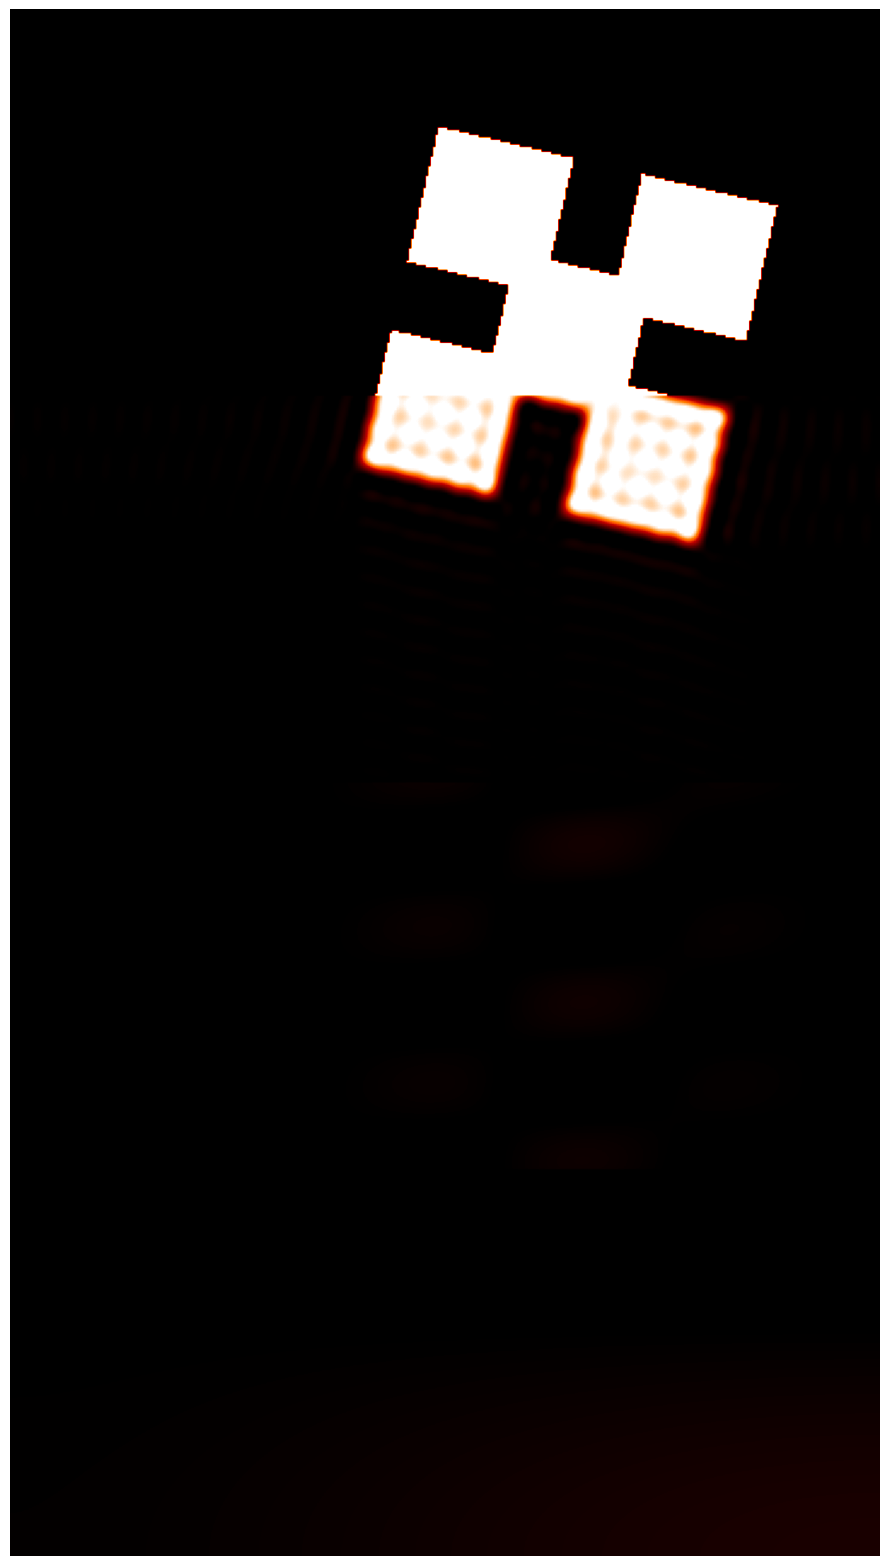

Budgets per band (kx_keep, ky_keep), top→bottom:
[(360, 640), (64, 113), (11, 20), (2, 4)]


In [3]:
# Parameters (keep N modest: DCT via matrix multiplies is O(N^3) per frame)
# Use a true 9:16 image (width:height = 9:16).
W = 90*4
H = 160*4
BANDS = 4
SQUARE_SIDE = 36*4

# Precompute separable basis matrices once (reused for single frame + animation)
DCT_Y = dct_matrix(H)
DCT_X = dct_matrix(W)

# Random pose
rng = np.random.default_rng(80)
cx = rng.uniform(0.2 * W, 0.8 * W)
cy = rng.uniform(0.2 * H, 0.8 * H)
theta = rng.uniform(0, 2 * np.pi)

img = make_rotated_square_image(H, W, (cx, cy), SQUARE_SIDE, theta, detail=True)
budgets = default_band_budgets(H, W, BANDS)
recon = reconstruct_stripwise(img, DCT_Y, DCT_X, strips=BANDS, budgets_xy=budgets, orientation='horizontal')
recon = clamp01(recon)

# Instagram-ish 9:16 canvas
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
ax.imshow(recon, cmap='gist_heat', vmin=0, vmax=1)
ax.axis('off')

# # Draw horizontal band boundaries for clarity
# edges = np.linspace(0, H, BANDS + 1)
# for e in edges[1:-1]:
#     ax.axhline(e - 0.5, color='white', linewidth=1.0, alpha=0.35)

plt.tight_layout()
plt.show()

print('Budgets per band (kx_keep, ky_keep), top→bottom:')
print(budgets)

## Animation (moving/rotating square)
A simple bounce simulation: the square moves with a velocity and reflects off the borders; angle advances each frame.

Note: because we recompute DCT reconstructions each frame, performance depends on `H`, `W`, `BANDS`, and the budgets.

In [6]:
# Animation parameters
FRAMES = 3
DT = 2.0

# Initial state
state = {
    "cx": float(0.25 * W),
    "cy": float(0.15 * H),
    "vx": float(1.2),
    "vy": float(0.9),
    "theta": float(0.3),
    "omega": float(0.02),
}

budgets = default_band_budgets(H, W, BANDS)

# Instagram-ish 9:16 canvas (composite only)
fig, ax = plt.subplots(1, 1, figsize=(9, 16))
im = ax.imshow(np.zeros((H, W)), cmap="gray", vmin=0, vmax=1)
ax.axis("off")

# ---- Overlay title + resolution ----
title_artist = ax.text(
    0.5,
    0.99,
    f"Discrete Cosine Transform (DCT2)\nResolution: {W}×{H}",
    transform=ax.transAxes,
    ha="center",
    va="top",
    color="white",
    fontsize=32,
    bbox=dict(facecolor="black", alpha=0.35, edgecolor="none", pad=4),
)

# ---- inverse DCT2 (IDCT2) equation (LaTeX/mathtext) ----
eq_tagline = ax.text(
    0.5,
    0.23,
    "Inverse DCT2 Reconstruction",
    transform=ax.transAxes,
    ha="center",
    va="top",
    color="white",
    fontsize=18,
    bbox=dict(facecolor="black", alpha=0.30, edgecolor="none", pad=4),
)

dct2_eq_artist = ax.text(
    0.5,
    0.2,
    r"$f_{y,x}=\sum_{v=0}^{V-1}\sum_{u=0}^{U-1}\alpha(u)\alpha(v)\,F_{u,v}\,"
    r"\cos\!\left(\frac{\pi(2y+1)u}{2H}\right)\cos\!\left(\frac{\pi(2x+1)v}{2W}\right)$",
    transform=ax.transAxes,
    ha="center",
    va="top",
    color="white",
    fontsize=20,
    bbox=dict(facecolor="black", alpha=0.30, edgecolor="none", pad=4),
)

# ---- Per-band Fourier/DCT term count labels (top-left of each band) ----
edges = np.linspace(0, H, BANDS + 1, dtype=int)
band_text_artists = []
for i in range(BANDS):
    y0, y1 = edges[i], edges[i + 1]
    kx_keep, ky_keep = budgets[i]
    n_terms = int(kx_keep) * int(ky_keep)

    band_text_artists.append(
        ax.text(
            6,
            y1 - 32,  # a bit below the band edge
            f"U={kx_keep}, V={ky_keep}\n{n_terms:,} terms",
            ha="left",
            va="top",
            color="white",
            fontsize=18,
            bbox=dict(facecolor="black", alpha=0.30, edgecolor="none", pad=2),
        )
    )

plt.tight_layout()
plt.close()

half = SQUARE_SIDE / 2.0


def step_state(st):
    # Advance rotation first; use the *new* angle to compute the square's current extents.
    theta_next = float(np.mod(st["theta"] + st["omega"] * DT, 2 * np.pi))
    st["theta"] = theta_next

    # For a rotated square, the axis-aligned half-extent is:
    # ex = half*(|cosθ| + |sinθ|), ey = half*(|cosθ| + |sinθ|)
    c = float(np.cos(theta_next))
    s = float(np.sin(theta_next))
    extent = half * (abs(c) + abs(s))  # same for x and y for a square
    pad_x = extent
    pad_y = extent

    # Predict next position
    nx = st["cx"] + st["vx"] * DT
    ny = st["cy"] + st["vy"] * DT

    # Reflect on x with overshoot correction (bounce exactly at the border)
    if nx < pad_x:
        nx = 2 * pad_x - nx
        st["vx"] *= -1
    elif nx > (W - pad_x):
        nx = 2 * (W - pad_x) - nx
        st["vx"] *= -1

    # Reflect on y with overshoot correction
    if ny < pad_y:
        ny = 2 * pad_y - ny
        st["vy"] *= -1
    elif ny > (H - pad_y):
        ny = 2 * (H - pad_y) - ny
        st["vy"] *= -1

    st["cx"] = float(nx)
    st["cy"] = float(ny)


def render_frame():
    img = make_rotated_square_image(
        H, W, (state["cx"], state["cy"]), SQUARE_SIDE, state["theta"], detail=True
    )
    recon = reconstruct_stripwise(
        img, DCT_Y, DCT_X, strips=BANDS, budgets_xy=budgets, orientation="horizontal"
    )
    return clamp01(recon)


def update(_frame_idx):
    del _frame_idx  # unused
    step_state(state)
    recon = render_frame()
    im.set_data(recon)
    return (im, title_artist, *band_text_artists)


# Allow larger embedded animations (in MB) for to_jshtml()/to_html5_video()
plt.rcParams["animation.embed_limit"] = 100  # MB

anim = animation.FuncAnimation(fig, update, frames=FRAMES, interval=50, blit=False)

### Knobs to tweak
- `W`, `H`: image width/height (kept at a true 9:16 ratio).
- `BANDS`: number of horizontal bands.
- `default_band_budgets(...)`: how aggressively you reduce terms toward the bottom.

If you want the bottom band to be *extremely* blurry, reduce the smallest level down to `2` or `3`.

In [7]:
import cv2

print("Starting manual MP4 generation using OpenCV...")

cv2_output = "stripwise_dct_animation.mp4"

# Derive FPS from the existing FuncAnimation interval (ms)
interval_ms = float(getattr(anim, "_interval", 50.0))
cv2_fps = 1000.0 / interval_ms

# Preserve current simulation state (update() mutates `state`)
_state_backup = dict(state)

fig.canvas.draw()
width, height = fig.canvas.get_width_height()

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
video_writer = cv2.VideoWriter(cv2_output, fourcc, cv2_fps, (width, height))
if not video_writer.isOpened():
    raise RuntimeError("Failed to open cv2 VideoWriter. Check codec support (mp4v).")

try:
    for frame_idx in range(FRAMES):
        update(frame_idx)          # advances `state` + updates `im`
        fig.canvas.draw()

        rgb = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(height, width, 3)
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        video_writer.write(bgr)

        if frame_idx % 50 == 0:
            print(f"Processed frame {frame_idx}/{FRAMES}")
finally:
    video_writer.release()
    state.update(_state_backup)  # restore state so the notebook isn't left "advanced"

print(f"Saved {cv2_output} @ {cv2_fps:.2f} FPS")

Starting manual MP4 generation using OpenCV...


RuntimeError: Failed to open cv2 VideoWriter. Check codec support (mp4v).

In [ ]:
HTML(anim.to_jshtml())
